In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import os
import sys

from importlib import reload

sys.path.append('')
import deck_load

import inspect

import warnings
warnings.filterwarnings("ignore")

In [2]:
deck_load = reload(deck_load)

In [3]:
# inspect.getmembers(deck_load.Deck, inspect.isfunction)

In [4]:
nasa = deck_load.Deck('NASA-GISS','GISS-E2-1-G','r102i1p1f1','ts')

In [5]:
nasa

DECK data for NASA-GISS GISS-E2-1-G 
**** ENS: r102i1p1f1 
**** VAR: ts

 --------------- 

Summary of: self.data
Coordinates:
  * time      (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'
Var: ts


In [6]:
nasa_anom = nasa.anomalies()
nasa_anom

Weighted Space mean of DECK data for NASA-GISS GISS-E2-1-G 
**** ENS: r102i1p1f1 
**** VAR: ts
Time frame: 1850 - 2014


In [7]:
nasa_anom_smean = nasa_anom.space_mean()
nasa_anom_smean

<xarray.DataArray 'ts' (scenario: 4, time: 165)>
dask.array<truediv, shape=(4, 165), dtype=float64, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

# Signal to Nosie Ratio - Rolling var detrend

* The signal is definal as the graident of the trend at a location.
* The noise is the standard deviation of the data.

In [8]:
nasa_anom_smean = nasa_anom_smean.compute()

In [9]:
def grid_trend(x):
    # If every point is just a nan values. We don't want to do the polyfit calculation. Just return nan
    t = np.arange(len(x))

    # Getting the gradient of a linear interpolation
    idx = np.isfinite(x) #checking where the nans.
    x = x[idx]
    
    if len(x) < 10:
        return np.nan
    
    grad = np.polyfit(t[idx],x,1)[0]

    return np.abs(grad)

In [10]:
def trend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_trend, axis[0], arr)

In [11]:
y = nasa_anom_smean.sel(scenario = '1pctCO2')
x = np.arange(len(y))

# Getting the gradient of a linear interpolation
idy = np.isfinite(y) #checking where the nans.
y = y[idy]
x = x[idy]

m,c = np.polyfit(x,y,1)

trend_line = m * x + c

y_detrend = y - trend_line

0.66 0.28


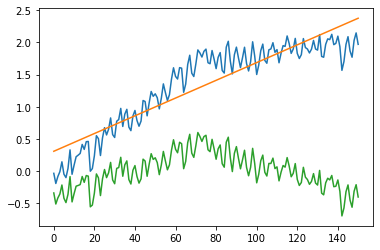

In [12]:
plt.plot(y)
plt.plot(trend_line)
plt.plot(y_detrend)

print(np.round(np.std(y.values),2), np.round(np.std(y_detrend.values),2))

In [13]:
def std_detrend(y):
    
    x = np.arange(len(y))

    # Getting the gradient of a linear interpolation
    idy = np.isfinite(y) #checking where the nans.
    y = y[idy]
    x = x[idy]

    if len(y) < 10:
        return np.nan
    
    m,c = np.polyfit(x,y,1)

    trend_line = m * x + c

    y_detrend = y - trend_line

    std_detrend = np.std(y_detrend)
    
    return std_detrend

In [14]:
def std_detrend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(std_detrend, axis[0], arr)

In [15]:
ROLL_PERIOD = 27

In [16]:
nasa_smean_noise = nasa_anom_smean.rolling(time = ROLL_PERIOD, center = True).reduce(std_detrend_helper)
nasa_smean_noise

(4, 165, 27) 2


<xarray.DataArray 'ts' (scenario: 4, time: 165)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.14837719, 0.1486927 ,
        0.15316308, 0.15374681, 0.15572137, 0.15385146, 0.15429769,
        0.15747555, 0.15862219, 0.1512812 , 0.14984858, 0.15455585,
        0.16165145, 0.16158798, 0.16143997, 0.16071209, 0.16698422,
        0.16695724, 0.16517536, 0.15374837, 0.14041724, 0.13397528,
        0.13906163, 0.13996997, 0.13018536, 0.12984776, 0.13269623,
        0.13231924, 0.13692581, 0.1314625 , 0.13316585, 0.12941321,
        0.13307463, 0.14306069, 0.13305952, 0.13305897, 0.13071923,
        0.12029743, 0.13605601, 0.13811899, 0.13915065, 0.14161104,
        0.14348053, 0.14242979, 0.13812591, 0.14142015, 0.1412103 ,
        0.13817447, 0.13859901, 0.13448217, 0.13843082, 0.14321073,
        0.14327798, 0.14073189, 0.14983742, 0.15070206, 0.14974362,
        0.15108268, 0.15259268, 0.15381699, 0.15633648, 0.15871429,
        0.16864194, 0.16849941, 0.16946305, 0.15313135, 0.14411829,
        0.14372553, 0.14534129, 0.14196827, 0.13500996, 0.13241234,
        0.14221232, 0.14171047, 0.14903022, 0.14859206, 0.14821865,
        0.15346025, 0.15334443, 0.15181755, 0.15322414, 0.15264188,
        0.15640682, 0.15408014, 0.15182276, 0.14865537, 0.14480477,
...
        0.10838192, 0.1055204 , 0.10339482, 0.10428116, 0.10492137,
        0.10481245, 0.10326387, 0.09315255, 0.09338625, 0.0923496 ,
        0.09697291, 0.09875409, 0.09538977, 0.09387188, 0.10070184,
        0.10600353, 0.10702519, 0.11088228, 0.11204061, 0.11289311,
        0.11012745, 0.11808743, 0.12251591, 0.12490725, 0.12516099,
        0.12192207, 0.12681332, 0.13060319, 0.13029651, 0.12784165,
        0.12583318, 0.12846654, 0.12840971, 0.13187075, 0.1426817 ,
        0.14383452, 0.14079265, 0.14387866, 0.14727234, 0.14686045,
        0.14415774, 0.13872648, 0.13445606, 0.14180375, 0.13782202,
        0.13813499, 0.1393154 , 0.13882073, 0.1360324 , 0.13501768,
        0.1310868 , 0.12380771, 0.12568412, 0.13215348, 0.1324456 ,
        0.1401514 , 0.14033061, 0.14043658, 0.13867561, 0.13647453,
        0.13654794, 0.1292132 , 0.12746392, 0.12771379, 0.12399968,
        0.12128151, 0.11943454, 0.12412142, 0.12390197, 0.1268954 ,
        0.11532793, 0.11547128, 0.11617381, 0.12029561, 0.11709803,
        0.13440179, 0.14745663, 0.1472726 , 0.15262771, 0.15205411,
        0.15095052, 0.15179728, 0.14107795, 0.14533022, 0.14541738,
        0.14687029, 0.14784122,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [17]:
nasa_smean_signal = nasa_anom_smean.rolling(time = ROLL_PERIOD, center = True).reduce(trend_helper)
nasa_smean_signal 

(4, 165, 27) 2


<xarray.DataArray 'ts' (scenario: 4, time: 165)>
array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan, 2.41783073e-02, 2.54893092e-02, 2.64281823e-02,
        2.56163142e-02, 2.46884652e-02, 2.67569245e-02, 2.70007184e-02,
        2.76483832e-02, 2.66296974e-02, 2.92005085e-02, 2.87807580e-02,
        2.67548227e-02, 2.50497820e-02, 2.51176800e-02, 2.57326423e-02,
        2.58936328e-02, 2.44589264e-02, 2.44648298e-02, 2.68505639e-02,
        2.47660742e-02, 2.05958196e-02, 1.92197670e-02, 2.14337243e-02,
        2.22308622e-02, 2.06894193e-02, 2.04144585e-02, 1.97470697e-02,
        1.92596236e-02, 2.09460960e-02, 2.26399733e-02, 2.08933555e-02,
        1.91576617e-02, 2.10862532e-02, 2.42524759e-02, 2.73458333e-02,
        2.74087829e-02, 3.00677691e-02, 3.28576932e-02, 2.99066447e-02,
        2.71621681e-02, 2.83565484e-02, 3.09399341e-02, 2.94371778e-02,
        2.63164880e-02, 2.49439115e-02, 2.75184305e-02, 2.91118473e-02,
        2.78254063e-02, 2.84073451e-02, 3.02913956e-02, 2.94468958e-02,
        2.84913846e-02, 2.83571095e-02, 2.52282503e-02, 2.18763250e-02,
        2.15416596e-02, 2.03936655e-02, 1.55876136e-02, 1.09622711e-02,
        1.13851013e-02, 1.37518276e-02, 1.22716142e-02, 8.71674780e-03,
        8.99214793e-03, 1.00148178e-02, 6.31347727e-03, 2.16044346e-03,
...
        6.72085416e-04, 2.94183883e-03, 3.68006240e-03, 1.24186474e-03,
        1.39767526e-04, 5.60351858e-04, 1.04377638e-03, 3.42243524e-03,
        4.53103403e-03, 5.85417981e-03, 5.17471289e-03, 2.99288282e-03,
        2.48178999e-03, 4.48573340e-03, 5.30998979e-03, 2.59825182e-03,
        2.71151916e-03, 4.36471921e-03, 2.32097343e-03, 1.50082382e-03,
        3.76486926e-03, 4.79722294e-03, 3.14817596e-03, 8.77221733e-04,
        7.30288166e-04, 2.44456314e-03, 2.66763833e-03, 1.57134188e-05,
        2.68270311e-03, 2.13138833e-03, 6.21257883e-04, 5.45795914e-04,
        1.99054486e-03, 2.40285146e-03, 8.63870245e-04, 1.38003499e-03,
        1.95675489e-03, 8.39473729e-06, 1.08452861e-03, 1.58698884e-03,
        5.49100584e-04, 2.18352240e-03, 1.61753187e-03, 5.05998404e-04,
        6.29022514e-04, 1.32050621e-03, 9.35633444e-04, 2.75626616e-03,
        2.65238006e-03, 3.02767729e-03, 3.77238486e-03, 4.91835310e-03,
        2.90085139e-03, 4.09400364e-04, 2.32077984e-03, 1.38080994e-03,
        3.79485064e-04, 2.10760710e-04, 2.24025028e-03, 4.36899466e-03,
        3.59871435e-03, 3.73446864e-03, 4.26812325e-03, 4.03496492e-03,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [18]:
nasa_smean_sn = nasa_smean_signal/nasa_smean_noise
nasa_smean_sn.coords

Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

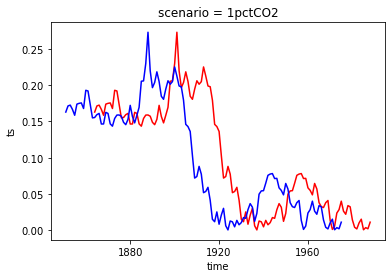

In [19]:
nasa_smean_sn.sel(scenario = '1pctCO2').plot(color = 'red')
nasa_smean_sn['time'] = nasa_smean_sn.time.values - pd.to_timedelta(f'{int((ROLL_PERIOD - 1)/2)}Y')
nasa_smean_sn.sel(scenario = '1pctCO2').plot(color = 'blue')

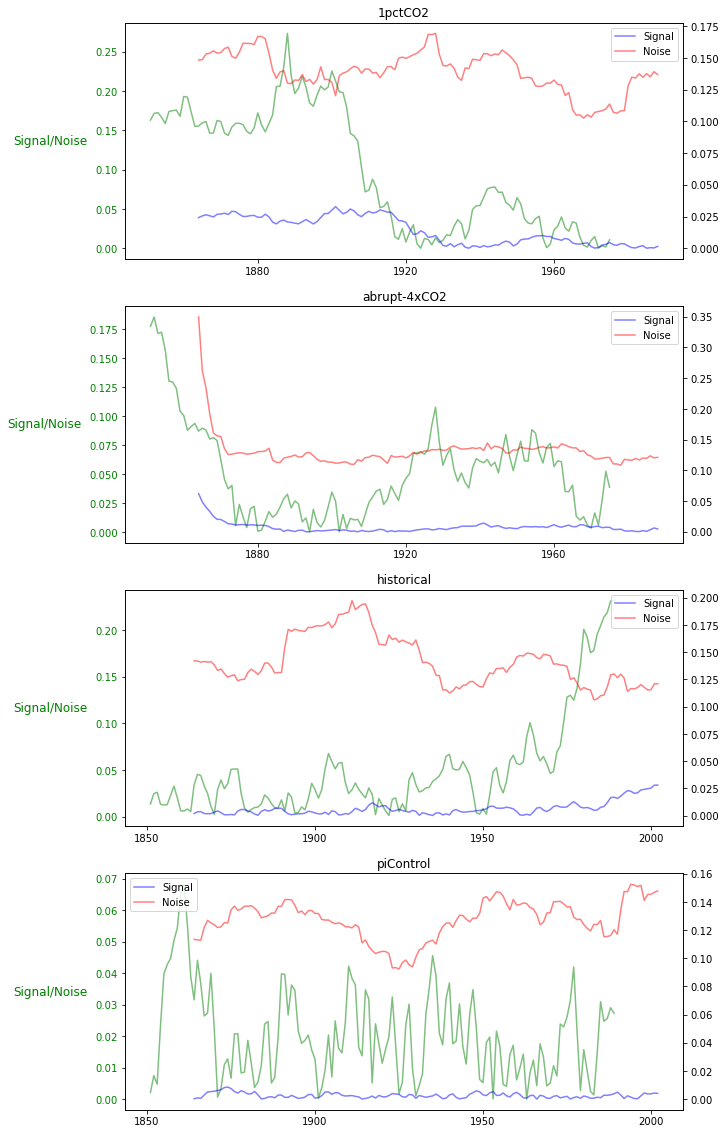

In [20]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
#     anom_data = nasa_anom_smean.sel(scenario = scenario)
    sn_data = nasa_smean_sn.sel(scenario = scenario)
    signal = nasa_smean_signal.sel(scenario = scenario)
    noise = nasa_smean_noise.sel(scenario = scenario)

    ax.plot(sn_data.time.values, sn_data.values, color = 'green',
            label = 'S/N', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Signal/Noise', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')

    ax2 = ax.twinx()
#     ax2.plot(sn_data.time.values, sn_data.values, color = 'purple', label = 'Signal/Noise', alpha = 0.5)
    ax2.plot(signal.time.values, signal.values, color = 'blue', label = 'Signal', alpha = 0.5)    
    ax2.plot(noise.time.values, noise.values, color = 'red', label = 'Noise', alpha = 0.5)
    ax2.set_ylabel('', size = 12, color = 'k', rotation = 0, labelpad = 45, va = 'center')
    
    ax2.legend()
    ax.set_title(scenario)

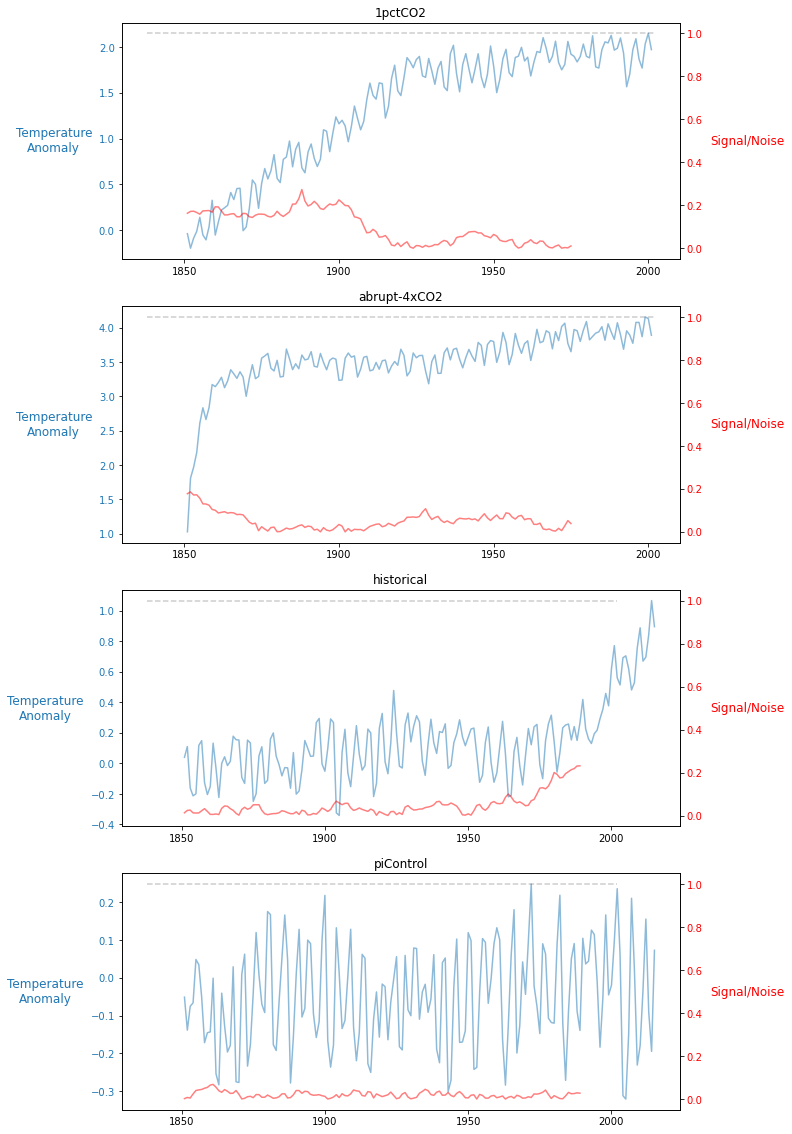

In [21]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
    anom_data = nasa_anom_smean.sel(scenario = scenario)
    sn_data = nasa_smean_sn.sel(scenario = scenario)

    
    ax.plot(anom_data.time.values, anom_data.values, label = 'Temperature Anomalies', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Temperature\nAnomaly', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')

    ax2 = ax.twinx()

    ax2.plot(sn_data.time.values, sn_data.values, color = 'red', label = 'S/N', alpha = 0.5)
    c2 = plt.gca().lines[0].get_color()
    ax2.tick_params(axis = 'y', labelcolor = c2)
    ax2.set_ylabel('Signal/Noise', size = 12, color = c2, rotation = 0, labelpad = 45, va = 'center')


    ax2.plot([sn_data.time.values[0],sn_data.time.values[-1]], [1,1], color = 'k', linestyle = '--', alpha = .2,
            zorder = -1);
    
    ax.set_title(scenario)

# Signal to Nosie Ratio

* The signal is definal as the graident of the trend at a location.
* The noise is the standard deviation of the data.

In [22]:
nasa_anom_smean = nasa_anom_smean.compute()

In [23]:
def grid_trend(x):
    # If every point is just a nan values. We don't want to do the polyfit calculation. Just return nan
    t = np.arange(len(x))

    # Getting the gradient of a linear interpolation
    idx = np.isfinite(x) #checking where the nans.
    x = x[idx]
    
    if len(x) < 10:
        return np.nan
    
    try:
        grad = np.polyfit(t[idx],x,1)[0]
    except ValueError:
        print(x)

    return grad

In [24]:
def trend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_trend, axis[0], arr)

In [25]:
ROLL_PERIOD = 27

In [26]:
nasa_smean_noise = nasa_anom_smean.rolling(time = ROLL_PERIOD, center = True).std()

In [27]:
nasa_smean_signal = nasa_anom_smean.rolling(time = ROLL_PERIOD, center = True).reduce(trend_helper)

(4, 165, 27) 2


In [28]:
nasa_smean_sn = nasa_smean_signal/nasa_smean_noise
nasa_smean_sn.coords

Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

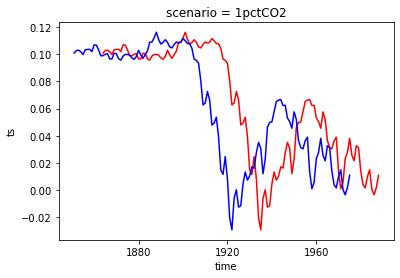

In [29]:
nasa_smean_sn.sel(scenario = '1pctCO2').plot(color = 'red')
nasa_smean_sn['time'] = nasa_smean_sn.time.values - pd.to_timedelta(f'{int((ROLL_PERIOD - 1)/2)}Y')
nasa_smean_sn.sel(scenario = '1pctCO2').plot(color = 'blue')

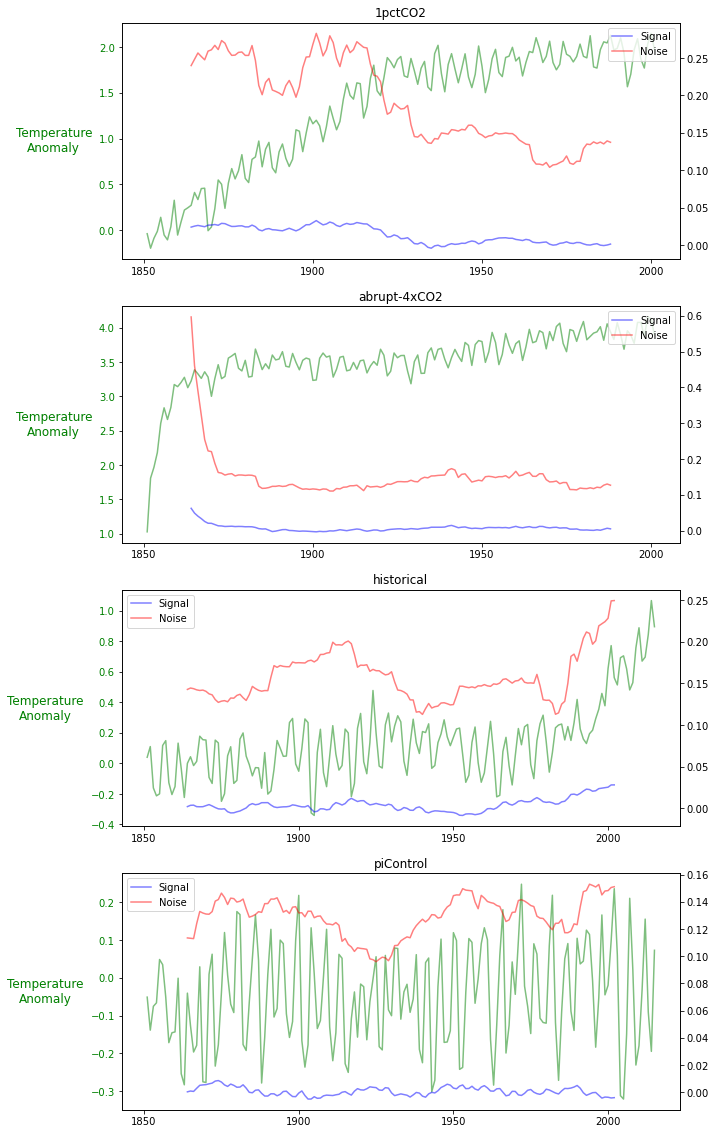

In [30]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
    anom_data = nasa_anom_smean.sel(scenario = scenario)
#     sn_data = nasa_smean_sn.sel(scenario = scenario)
    signal = nasa_smean_signal.sel(scenario = scenario)
    noise = nasa_smean_noise.sel(scenario = scenario)

    
    ax.plot(anom_data.time.values, anom_data.values, color = 'green',
            label = 'Temperature Anomalies', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Temperature\nAnomaly', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')

    ax2 = ax.twinx()

#     ax2.plot(sn_data.time.values, sn_data.values, color = 'purple', label = 'Signal/Noise', alpha = 0.5)
    
    ax2.plot(signal.time.values, signal.values, color = 'blue', label = 'Signal', alpha = 0.5)    
    ax2.plot(noise.time.values, noise.values, color = 'red', label = 'Noise', alpha = 0.5)
    ax2.set_ylabel('', size = 12, color = 'k', rotation = 0, labelpad = 45, va = 'center')
    
    ax2.legend()
    
    ax.set_title(scenario)

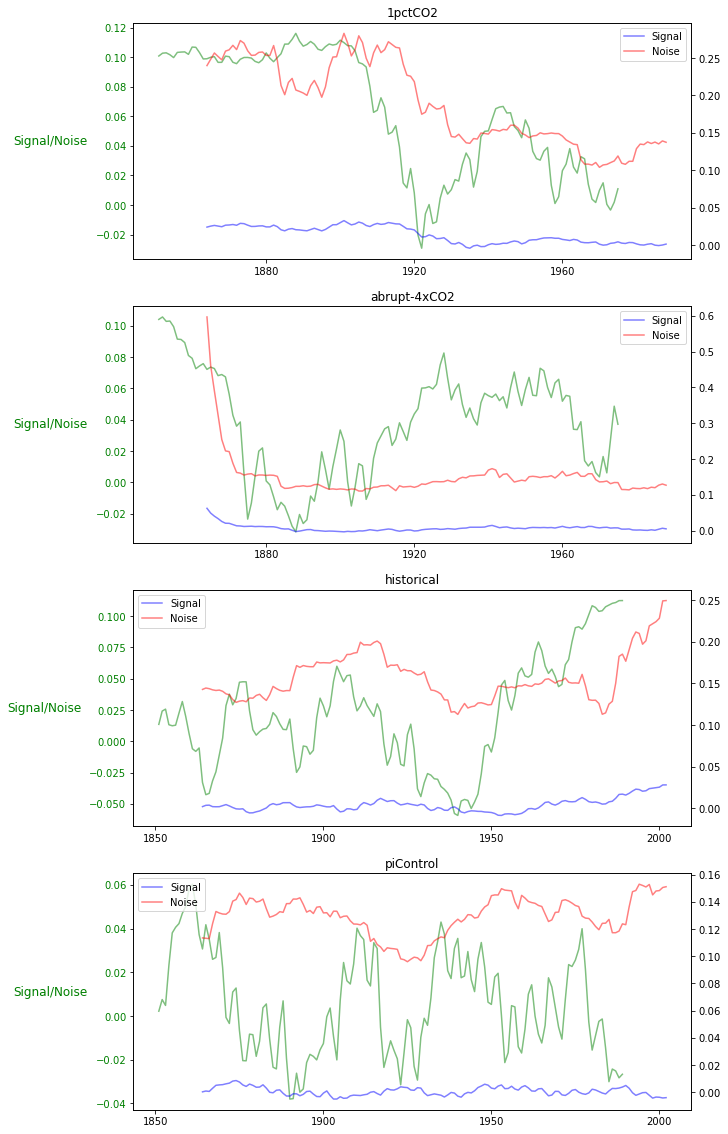

In [31]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
#     anom_data = nasa_anom_smean.sel(scenario = scenario)
    sn_data = nasa_smean_sn.sel(scenario = scenario)
    signal = nasa_smean_signal.sel(scenario = scenario)
    noise = nasa_smean_noise.sel(scenario = scenario)

    
    ax.plot(sn_data.time.values, sn_data.values, color = 'green',
            label = 'S/N', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Signal/Noise', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')

    ax2 = ax.twinx()

#     ax2.plot(sn_data.time.values, sn_data.values, color = 'purple', label = 'Signal/Noise', alpha = 0.5)
    
    ax2.plot(signal.time.values, signal.values, color = 'blue', label = 'Signal', alpha = 0.5)    
    ax2.plot(noise.time.values, noise.values, color = 'red', label = 'Noise', alpha = 0.5)
    ax2.set_ylabel('', size = 12, color = 'k', rotation = 0, labelpad = 45, va = 'center')
    
    ax2.legend()
    
    ax.set_title(scenario)

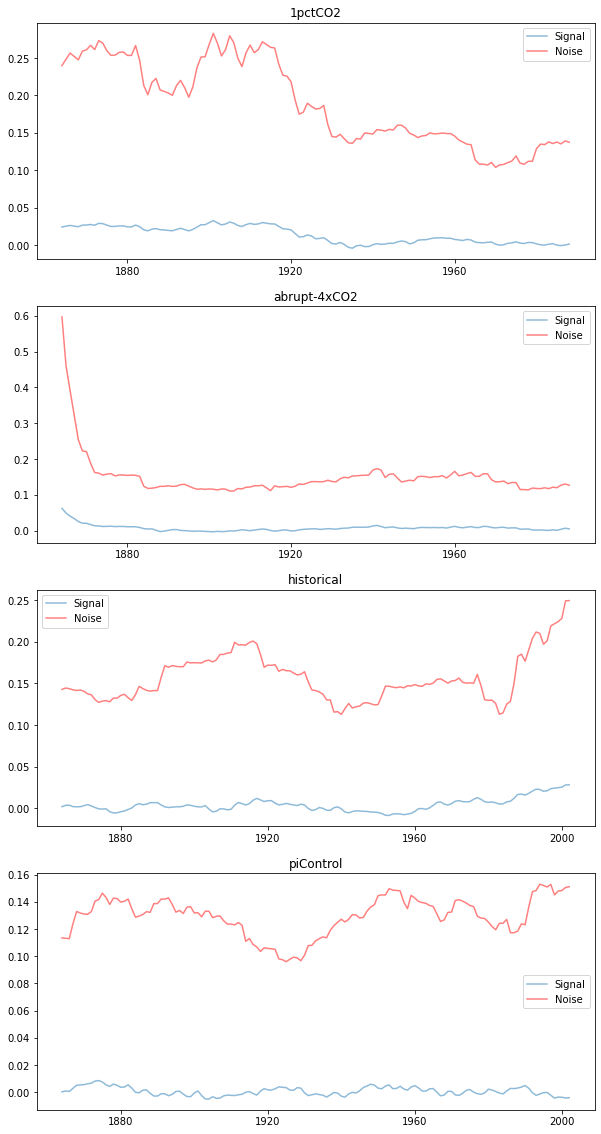

In [32]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
    signal = nasa_smean_signal.sel(scenario = scenario)
    noise = nasa_smean_noise.sel(scenario = scenario)

    ax.plot(signal.time.values, signal.values, label = 'Signal', alpha = 0.5)    
    ax.plot(noise.time.values, noise.values, color = 'red', label = 'Noise', alpha = 0.5)
    
    ax.legend()
    ax.set_title(scenario)

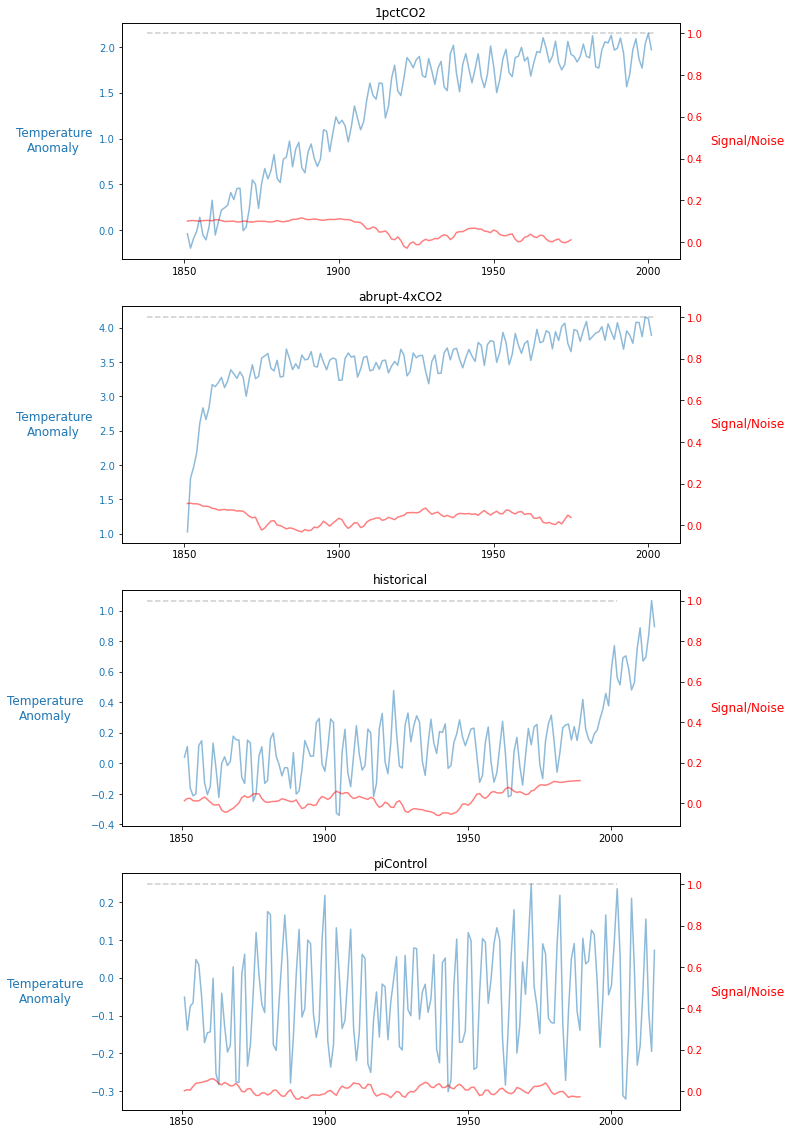

In [33]:
fig = plt.figure(figsize = (10,20))
gs = gridspec.GridSpec(4,1)

for plot_num,scenario in enumerate(nasa_anom_smean.scenario.values):
    
    ax = fig.add_subplot(gs[plot_num])
    
    anom_data = nasa_anom_smean.sel(scenario = scenario)
    sn_data = nasa_smean_sn.sel(scenario = scenario)

    
    ax.plot(anom_data.time.values, anom_data.values, label = 'Temperature Anomalies', alpha = 0.5)
    c1 = plt.gca().lines[0].get_color()
    ax.tick_params(axis = 'y', labelcolor = c1)
    ax.set_ylabel('Temperature\nAnomaly', size = 12, color = c1, rotation = 0, labelpad = 45, va = 'center')

    ax2 = ax.twinx()

    ax2.plot(sn_data.time.values, sn_data.values, color = 'red', label = 'S/N', alpha = 0.5)
    c2 = plt.gca().lines[0].get_color()
    ax2.tick_params(axis = 'y', labelcolor = c2)
    ax2.set_ylabel('Signal/Noise', size = 12, color = c2, rotation = 0, labelpad = 45, va = 'center')


    ax2.plot([sn_data.time.values[0],sn_data.time.values[-1]], [1,1], color = 'k', linestyle = '--', alpha = .2,
            zorder = -1);
    
    ax.set_title(scenario)

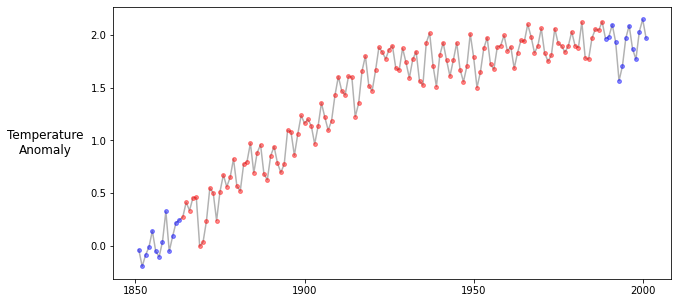

In [34]:
anom_data = nasa_anom_smean.sel(scenario = '1pctCO2')
sn_data = nasa_smean_sn.sel(scenario = '1pctCO2')
sn_data = sn_data.where(sn_data < 1)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(anom_data.time.values, anom_data.values, label = 'Temperature Anomalies', alpha = 0.3,
       color = 'k', zorder = -1)
 
for i in np.arange(len(anom_data.values) - 1):
    y = anom_data.values[i]
    x = anom_data.time.values[i]
    
    c = 'red' if sn_data.values[i] < 1 else 'blue'

    ax.scatter(x,y, color = c, alpha = 0.45, s = 15)

ax.set_ylabel('Temperature\nAnomaly', size = 12, rotation = 0, labelpad = 45, va = 'center');